In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

In [3]:
WORKING_DIRECTORY = './drive/MyDrive/Colab\ Notebooks/diploma/'

In [4]:
 # Создаём SparkSession
spark = SparkSession.builder \
    .appName("PetCo") \
    .getOrCreate()

# Сначала изучим изначальный датасет со всеми видами действий юзеров в каталоге

In [5]:
# Read dataset with beh logs
data_logs = spark.read.parquet(WORKING_DIRECTORY+'data/needed_beh_logs')

In [ ]:
data_logs.show()

+----------------+--------------------+-----+--------------------+--------------------+--------------------+-----------------+-------------+--------------------+--------------------+-----------+--------------------+------------+--------------------+--------------------+--------------------+-------+
|customer_user_id|              ac_key|ac_id|             user_id|          session_id|           timestamp|         raw_term|  filter_name|        filter_value|              action|customer_id|           item_name|variation_id|      variation_name|               items|            items_v2|revenue|
+----------------+--------------------+-----+--------------------+--------------------+--------------------+-----------------+-------------+--------------------+--------------------+-----------+--------------------+------------+--------------------+--------------------+--------------------+-------+
|       435675978|key_afiSr5Y4gCaaSW5X| 2560|e5fbf045-94fa-498...|e5fbf045-94fa-498...|2024-11-29 10

In [ ]:
data_logs.printSchema()  # Структура данных

root
 |-- customer_user_id: string (nullable = true)
 |-- ac_key: string (nullable = true)
 |-- ac_id: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- session_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- raw_term: string (nullable = true)
 |-- filter_name: string (nullable = true)
 |-- filter_value: string (nullable = true)
 |-- action: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- item_name: string (nullable = true)
 |-- variation_id: long (nullable = true)
 |-- variation_name: string (nullable = true)
 |-- items: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- customer_id: string (nullable = true)
 |    |    |-- item_id: long (nullable = true)
 |    |    |-- item_name: string (nullable = true)
 |    |    |-- price: double (nullable = true)
 |-- items_v2: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- customer_id: string (nullabl

In [ ]:
print(f'Число строк: {data_logs.count()}')

Число строк: 5465431


In [ ]:
n_users = data_logs.select('customer_user_id').distinct().count()
print(f'Число пользователей: {n_users}')

Число пользователей: 20000


In [ ]:
# Предположим, что df — это ваш DataFrame
#data_logs = data_logs.withColumn("timestamp", F.col("timestamp").cast("timestamp"))
data_logs = data_logs.withColumn("formatted_timestamp", F.date_format("timestamp", "yyyy-MM-dd HH:mm:ss"))
# Нахождение минимальной и максимальной даты
min_date = data_logs.agg(F.min("formatted_timestamp").alias("min_date")).collect()[0]["min_date"]
max_date = data_logs.agg(F.max("formatted_timestamp").alias("max_date")).collect()[0]["max_date"]

print(f"Разброс дат: {min_date, max_date}")

Разброс дат: ('2024-06-06 00:00:09', '2024-12-02 23:59:55')


In [ ]:
# Группируем по 'user_id' и считаем количество строк для каждого 'user_id'
user_counts = data_logs.groupBy("customer_user_id").count()
average_count = user_counts.agg(F.avg("count")).collect()[0][0]
median_count = user_counts.approxQuantile('count', [0.5], 0.01)[0]

print(f"Среднее число итеракций: {round(average_count, 1)}")
print(f'Медианное число итеракций: {median_count}')

Среднее число итеракций: 273.3
Медианное число итеракций: 208.0


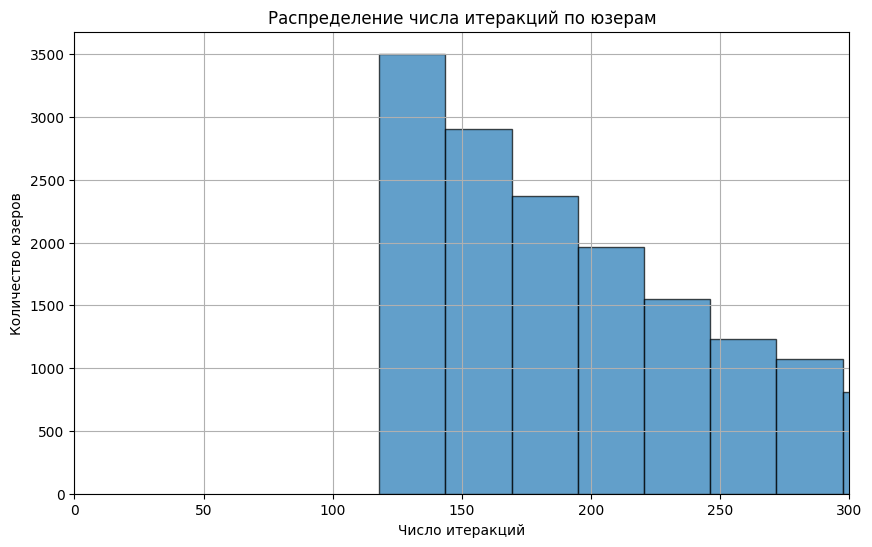

In [ ]:
# Преобразуем в pandas DataFrame
user_counts_pd = user_counts.toPandas()

# Строим гистограмму распределения
plt.figure(figsize=(10, 6))
plt.hist(user_counts_pd['count'], bins=400, edgecolor='black', alpha=0.7)
plt.title("Распределение числа итеракций по юзерам")
plt.xlabel("Число итеракций")
plt.ylabel("Количество юзеров")
plt.grid(True)
plt.xlim(left=0, right=300)
plt.show()

# Теперь изучим только конверсии юзеров (добавление товара в каталог)

In [7]:
data_conversions = data_logs.filter(data_logs.action == 'conversion')
print(f'Number of conversions: {data_conversions.count()}')

Number of conversions: 449982


In [8]:
data_conversions.show()

+----------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+-----------+------------+----------+-----------+--------------------+------------+--------------------+-----+--------+-------+
|customer_user_id|              ac_key|ac_id|             user_id|          session_id|           timestamp|            raw_term|filter_name|filter_value|    action|customer_id|           item_name|variation_id|      variation_name|items|items_v2|revenue|
+----------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+-----------+------------+----------+-----------+--------------------+------------+--------------------+-----+--------+-------+
|       635619080|key_afiSr5Y4gCaaSW5X| 1947|6521ca44-0aed-409...|6521ca44-0aed-409...|2024-11-29 01:44:...|wholehearted wet ...|       NULL|        NULL|conversion|    5196262|WholeHearted Lamb...|  1864394695|WholeHearted Lamb...|

In [19]:
n_users_conversed = data_conversions.select('customer_user_id').distinct().count()
print(f'Число пользователей, которые добавляли товары в корзину: {n_users_conversed}')

Число пользователей, которые добавляли товары в корзину: 19688


In [20]:
# Группируем по 'customer_user_id' и считаем количество строк для каждого 'customer_user_id'
user_counts_conversed = data_conversions.groupBy("customer_user_id").count()
average_count_conversions = user_counts_conversed.agg(F.avg("count")).collect()[0][0]
median_count_conversions = user_counts_conversed.approxQuantile('count', [0.5], 0.01)[0]

print(f"Среднее число конверсий для юзера: {round(average_count_conversions, 1)}")
print(f'Медианное число конверсий для юзера: {median_count_conversions}')

Среднее число конверсий для юзера: 22.9
Медианное число конверсий для юзера: 16.0


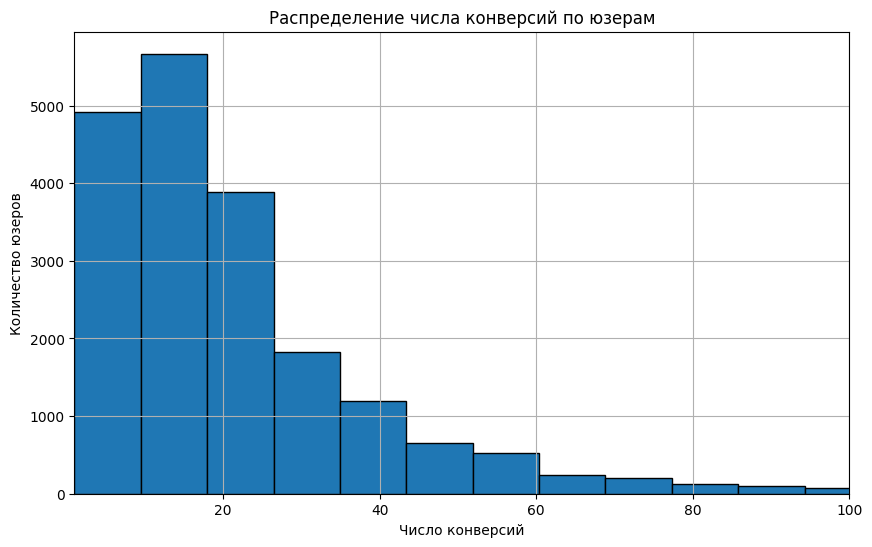

In [16]:
# Преобразуем в pandas DataFrame
user_counts_pd_conversions = user_counts_conversed.toPandas()

# Строим гистограмму распределения
plt.figure(figsize=(10, 6))
plt.hist(user_counts_pd_conversions['count'], bins=100, edgecolor='black')
plt.title("Распределение числа конверсий по юзерам")
plt.xlabel("Число конверсий")
plt.ylabel("Количество юзеров")
plt.grid(True)
plt.xlim(left=1, right=100)
plt.show()

In [18]:
n_items_conversed = data_conversions.select('customer_id').distinct().count()
print(f'Число товаров, которые добавляли в корзину: {n_items_conversed}')

Число товаров, которые добавляли в корзину: 18724


In [21]:
# Группируем по 'customer_user_id' и считаем количество строк для каждого 'customer_user_id'
item_counts_conversed = data_conversions.groupBy("customer_id").count()
average_count_conversions = item_counts_conversed.agg(F.avg("count")).collect()[0][0]
median_count_conversions = item_counts_conversed.approxQuantile('count', [0.5], 0.01)[0]

print(f"Среднее число конверсий для товара: {round(average_count_conversions, 1)}")
print(f'Медианное число конверсий для товара: {median_count_conversions}')

Среднее число конверсий для товара: 24.0
Медианное число конверсий для товара: 6.0


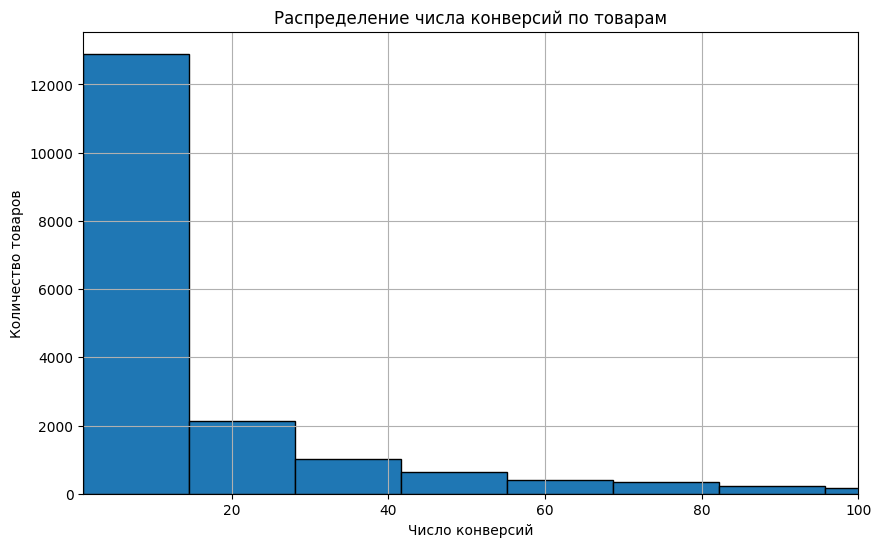

In [23]:
# Преобразуем в pandas DataFrame
item_counts_pd_conversions = item_counts_conversed.toPandas()

# Строим гистограмму распределения
plt.figure(figsize=(10, 6))
plt.hist(item_counts_pd_conversions['count'], bins=100, edgecolor='black')
plt.title("Распределение числа конверсий по товарам")
plt.xlabel("Число конверсий")
plt.ylabel("Количество товаров")
plt.grid(True)
plt.xlim(left=1, right=100)
plt.show()

# **Вывод**

Можно брать за отдельного юзера отдельный user_id (id незалогированного юзера) или отдельный customer_user_id (id залогированного юзера). Если брать user_id: юзеров около 70 тысяч (хорошо), средняя длина групповых покупок 1.8, а единичных - 7 (маловато, но можно). Если брать customer_user_id: юзеров 18 тысяч (достаточно), средняя длина групповых покупок 5.5, а единичных покупок 19 (хорошо, в статье с Амазоном 7.6). Логично рассматривать customer_user_id, так как они обозначают одних и тех же людей, в то время как user_id разбивает одного юзера на серии покупок (что излишне).

Всего групповых покупок около 98 тысяч, а единичных - 339 тысяч, в среднем за одну покупку покупается около 3.5 товаров.

Также каждый товар покупается в среднем 10.6 раз

# **Вопросы:**

1. Какую давать последовательность товарам внутри одной групповой покупки
(одинаковую, или порядок их занесения в корзину, или тот порядок, как они уже находятся в столбце 'items')
2. Надо же рассматривать именно единичные покупки? (вроде, да)